# Building an Agent to Play Miss PacMan games using Deep Q Network, in Tensorflow 2.0.

### A Colaboratory notebook for GradientCrescent, by Adrian Yijie Xu.

### If you enjoyed this notebook, please consider leaving a star on the GradientCrescent Github (https://github.com/EXJUSTICE/GradientCrescent), and visting the publication for more articles on applied and theoretical aspects of AI (https://medium.com/gradientcrescent).


In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


## Training

First we import all the necessary libraries </font> 


In [ ]:
import numpy as np
import gym
import tensorflow as tf
from tensorflow.contrib.layers import flatten, conv2d, fully_connected
from collections import deque, Counter
import random
from datetime import datetime

In [ ]:
print(tf.__version__)

1.15.2


Now we define a preprocessing function for our input game screens. We crop the image size convert the image into greyscale 1D tensor



In [ ]:
color = np.array([210, 164, 74]).mean()


#prepro (210, 160, 3) uint8 frame into 7040 (88x80) 1D float vector 

def preprocess_observation(obs):

    # Crop and resize the image
    img = obs[1:176:2, ::2]

    # Convert the image to greyscale
    img = img.mean(axis=2)

    # Improve image contrast
    img[img==color] = 0

    # Next we normalize the image from -1 to +1
    img = (img - 128) / 128 - 1

    return img.reshape(88,80,1)


Let us initialize our gym environment, and take a look at some observations. Let's also inspect the size and type of action space in this game.

9
['NOOP', 'UP', 'RIGHT', 'LEFT', 'DOWN', 'UPRIGHT', 'UPLEFT', 'DOWNRIGHT', 'DOWNLEFT']


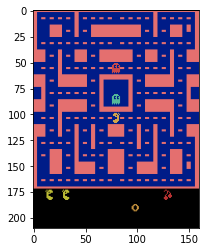

In [ ]:
env = gym.make("MsPacman-v0")
n_outputs = env.action_space.n
print(n_outputs)
print(env.env.get_action_meanings())

observation = env.reset()

import tensorflow as tf
import matplotlib.pyplot as plt


for i in range(22):
  
  if i > 20:
    plt.imshow(observation)
    plt.show()

  observation, _, _, _ = env.step(1)
  

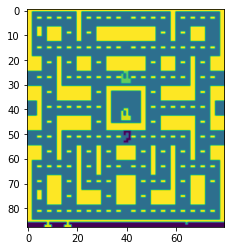

(210, 160, 3)
(88, 80)


In [ ]:
#Take a look at the preprocessed inputs in greyscale
#Let's compare the original and preprocessed tensors.

obs_preprocessed = preprocess_observation(observation).reshape(88,80)
plt.imshow(obs_preprocessed)
plt.show()
print(observation.shape)
print(obs_preprocessed.shape)

Okay, Now we define a function called q_network for building our Deep Q network.  <br>
We build Q network with three convolutional layers with same padding followed by a flattening, and a fully connected layer. 

In [ ]:
tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 


        # initialize the convolutional layers
       
        layer_1 = conv2d(X, num_outputs=32, kernel_size=(8,8), stride=4, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=64, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=64, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_3)
        # Insert fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output

In [ ]:
tf.compat.v1.reset_default_graph()
#Reset is technically not necessary if variables done  in TF2
#https://github.com/ageron/tf2_course/issues/8

def q_network(X, name_scope):
    
    # Initialize layers
    initializer = tf.compat.v1.keras.initializers.VarianceScaling(scale=2.0)

    with tf.compat.v1.variable_scope(name_scope) as scope: 


        # initialize the convolutional layers
        layer_1 = conv2d(X, num_outputs=8, kernel_size=(5,5), stride=2, padding='SAME', weights_initializer=initializer) 
        tf.compat.v1.summary.histogram('layer_1',layer_1)
        
        layer_2 = conv2d(layer_1, num_outputs=16, kernel_size=(4,4), stride=2, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_2',layer_2)
        
        layer_3 = conv2d(layer_2, num_outputs=32, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_3',layer_3)

        layer_4 = conv2d(layer_3, num_outputs=32, kernel_size=(3,3), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_4',layer_4)

        layer_5 = conv2d(layer_4, num_outputs=64, kernel_size=(2,2), stride=1, padding='SAME', weights_initializer=initializer)
        tf.compat.v1.summary.histogram('layer_5',layer_5)
        
        # Flatten the result of layer_3 before feeding to the fully connected layer
        flat = flatten(layer_5)
        # Insert fully connected layer
        fc = fully_connected(flat, num_outputs=128, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('fc',fc)
        #Add final output layer
        output = fully_connected(fc, num_outputs=n_outputs, activation_fn=None, weights_initializer=initializer)
        tf.compat.v1.summary.histogram('output',output)
        

        # Vars will store the parameters of the network such as weights
        vars = {v.name[len(scope.name):]: v for v in tf.compat.v1.get_collection(key=tf.compat.v1.GraphKeys.TRAINABLE_VARIABLES, scope=scope.name)} 
        #Return both variables and outputs together
        return vars, output

Next we define a function called epsilon_greedy for performing epsilon greedy policy.

In epsilon greedy policy we either select the best action with probability [1 - epsilon] or a random action with
probability [epsilon].


We use decaying epsilon greedy policy where value of epsilon will be decaying over time as we don't want to explore
forever. So over time our policy will be exploiting only good actions.




In [ ]:
epsilon = 1
eps_min = 0.05
eps_max = 1.0
eps_decay_steps = 500000

#
def epsilon_greedy(action, step):
    p = np.random.random(1).squeeze() #1D entries returned using squeeze
    epsilon = max(eps_min, eps_max - (eps_max-eps_min) * step/eps_decay_steps) #Decaying policy with more steps
    if np.random.rand() < epsilon:
        return np.random.randint(n_outputs)
    else:
        return action

Now, we initialize our  buffer of length 20000 which holds the gameplay information in SARSA.

We store all the agent's experience i.e (state, action, rewards) in the experience replay buffer
and  we sample from this minibatch of experience for generating the y-values for the update function, and hence train the network.



In [ ]:
buffer_len = 20000
#Buffer is made from a deque - double ended queue
exp_buffer = deque(maxlen=buffer_len)

Next, we define a function called sample_memories for sampling experiences from the memory according to batches. Batch size is the number of experience sampled
from the memory.


In [ ]:
def sample_memories(batch_size):
    perm_batch = np.random.permutation(len(exp_buffer))[:batch_size]
    mem = np.array(exp_buffer)[perm_batch]
    return mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]


Now we define our network hyperparameters,

In [ ]:
num_episodes = 400
batch_size = 48
input_shape = (None, 88, 80, 1)
#Recall shape is img.reshape(88,80,1)
learning_rate = 0.001
X_shape = (None, 88, 80, 1)
discount_factor = 0.97

global_step = 0
copy_steps = 100
steps_train = 4
start_steps = 2000

In [ ]:
logdir = 'logs'
tf.compat.v1.reset_default_graph()

# Now we define the placeholder for our input i.e game state
X = tf.compat.v1.placeholder(tf.float32, shape=X_shape)

# we define a boolean called in_training_model to toggle the training
in_training_mode = tf.compat.v1.placeholder(tf.bool)

 Now let us build our primary and target Q network We have two networks to allow for training and data generation to occur concurrently.
 Note that the network returns the weights, as well as network outputs. 

In [ ]:
# we build our Q network, which takes the input X and generates Q values for all the actions in the state
mainQ, mainQ_outputs = q_network(X, 'mainQ')

# similarly we build our target Q network
targetQ, targetQ_outputs = q_network(X, 'targetQ')


Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.flatten instead.


In [ ]:
# define the placeholder for our action values

X_action = tf.compat.v1.placeholder(tf.int32, shape=(None,))
Q_action = tf.reduce_sum(input_tensor=targetQ_outputs * tf.one_hot(X_action, n_outputs), axis=-1, keepdims=True)


Copy the primary Q network parameters to the target  Q network

In [ ]:

copy_op = [tf.compat.v1.assign(main_name, targetQ[var_name]) for var_name, main_name in mainQ.items()]
copy_target_to_main = tf.group(*copy_op)


Compute and optimize loss using gradient descent optimizer


In [ ]:
# define a placeholder for our output i.e action
y = tf.compat.v1.placeholder(tf.float32, shape=(None,1))

# now we calculate the loss which is the difference between actual value and predicted value
loss = tf.reduce_mean(input_tensor=tf.square(y - Q_action))

# we use adam optimizer for minimizing the loss
optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)

init = tf.compat.v1.global_variables_initializer()

loss_summary = tf.compat.v1.summary.scalar('LOSS', loss)
merge_summary = tf.compat.v1.summary.merge_all()
file_writer = tf.compat.v1.summary.FileWriter(logdir, tf.compat.v1.get_default_graph())


 Now we start the tensorflow session and run the model,

1. First, we preprocess and feed the game screen (state s) to our DQN, which will
return the Q values of all possible actions in the state.
2. Now we select an action using the epsilon-greedy policy: with the probability
epsilon, we select a random action a and with probability 1-epsilon, we select an
action that has a maximum Q value, such as .
3. After selecting the action a, we perform this action in a state s and move to a new
state s' and receive a reward. The next state, s', is the preprocessed image of the
next game screen.
4. We store this transition in our replay buffer as <s,a,r,s'>.
5. Next, we sample some random batches of transitions from the replay buffer and
calculate the loss.

6. We know that the loss is defined as the squared
difference between target Q and predicted Q.

7. We perform gradient descent with respect to our actual network parameters in
order to minimize this loss.

8. Copy weights of training network to actual network
9. Repeat for M steps

Epochs here exist because we are suplying data in batches.

In [ ]:
with tf.compat.v1.Session() as sess:
    init.run()
    
    # for each episode
    history = []
    for i in range(num_episodes):
        done = False
        obs = env.reset()
        epoch = 0
        episodic_reward = 0
        actions_counter = Counter() 
        episodic_loss = []

        # while the state is not the terminal state
        while not done:

           #env.render()
        
            # get the preprocessed game screen
            obs = preprocess_observation(obs)

            # feed the game screen and get the Q values for each action,  FEED THE NETWORK BY CALLING THE OUTPUT LAYER
            
            actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

            # get the action
            action = np.argmax(actions, axis=-1)
            actions_counter[str(action)] += 1 

            # select the action using epsilon greedy policy
            action = epsilon_greedy(action, global_step)
            
            # now perform the action and move to the next state, next_obs, receive reward
            next_obs, reward, done, _ = env.step(action)

            # Store this transistion as an experience in the replay buffer! Quite important
            exp_buffer.append([obs, action, preprocess_observation(next_obs), reward, done])
            
            # After certain steps, we train our Q network with samples from the experience replay buffer
            if global_step % steps_train == 0 and global_step > start_steps:
                
                # sample experience, mem[:,0], mem[:,1], mem[:,2], mem[:,3], mem[:,4]
                o_obs, o_act, o_next_obs, o_rew, o_done = sample_memories(batch_size)

                # states
                o_obs = [x for x in o_obs]

                # next states
                o_next_obs = [x for x in o_next_obs]

                # next actions
                next_act = mainQ_outputs.eval(feed_dict={X:o_next_obs, in_training_mode:False})


                # discounted reward: these are our Y-values
                y_batch = o_rew + discount_factor * np.max(next_act, axis=-1) * (1-o_done) 

                # merge all summaries and write to the file
                mrg_summary = merge_summary.eval(feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:False})
                file_writer.add_summary(mrg_summary, global_step)

                # To calculate the loss, we run the previously defined functions mentioned while feeding inputs
                train_loss, _ = sess.run([loss, training_op], feed_dict={X:o_obs, y:np.expand_dims(y_batch, axis=-1), X_action:o_act, in_training_mode:True})
                episodic_loss.append(train_loss)
            
            # after some interval we copy our main Q network weights to target Q network
            if (global_step+1) % copy_steps == 0 and global_step > start_steps:
                copy_target_to_main.run()
                
            obs = next_obs
            epoch += 1
            global_step += 1
            episodic_reward += reward
        
        history.append(episodic_reward)
        print('Epochs per episode:', epoch, 'Episode Reward:', episodic_reward,"Episode number:", len(history))
    



Epochs per episode: 880 Episode Reward: 680.0 Episode number: 1
Epochs per episode: 686 Episode Reward: 140.0 Episode number: 2


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  This is separate from the ipykernel package so we can avoid doing imports until


Epochs per episode: 648 Episode Reward: 200.0 Episode number: 3
Epochs per episode: 509 Episode Reward: 160.0 Episode number: 4
Epochs per episode: 890 Episode Reward: 230.0 Episode number: 5
Epochs per episode: 707 Episode Reward: 210.0 Episode number: 6
Epochs per episode: 705 Episode Reward: 200.0 Episode number: 7
Epochs per episode: 599 Episode Reward: 180.0 Episode number: 8
Epochs per episode: 643 Episode Reward: 200.0 Episode number: 9
Epochs per episode: 675 Episode Reward: 200.0 Episode number: 10
Epochs per episode: 646 Episode Reward: 250.0 Episode number: 11
Epochs per episode: 692 Episode Reward: 190.0 Episode number: 12
Epochs per episode: 621 Episode Reward: 180.0 Episode number: 13
Epochs per episode: 605 Episode Reward: 140.0 Episode number: 14
Epochs per episode: 633 Episode Reward: 180.0 Episode number: 15
Epochs per episode: 829 Episode Reward: 290.0 Episode number: 16
Epochs per episode: 500 Episode Reward: 180.0 Episode number: 17
Epochs per episode: 711 Episode 

Let's plot our reward distribution across the incremental episodes. Remember to interrupt the training process first.

In [ ]:
#calculating the average
reward=0
threshold=600
numberOfHighScores=0
for i in range(len(history)):
  reward=reward+history[i]
  if history[i]>=threshold:
    numberOfHighScores=numberOfHighScores+1
reward=reward/len(history)
print("the average reward for this model is \n",reward,"and the number of high scores is : {}".format(numberOfHighScores))


the average reward for this model is 
 357.125 and the number of high scores is : 48


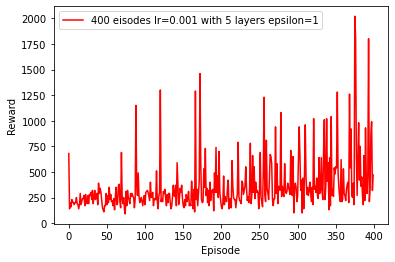

In [ ]:
plt.plot(history,'r',label="400 eisodes lr=0.001 with 5 layers epsilon=1")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.legend()
plt.show()

## Evaluation

Finally, let's visualize our agent's performance, and play a game within the gym environment itself.

In [ ]:
#Visualization cobe for running within Colab

# Install dependencies first for graphics visualization within Colaboratory

#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1



     |████████████████████████████████| 788kB 11.7MB/s 
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
  Found existing installation: setuptools 56.1.0
    Uninstalling setuptools-56.1.0:
      Successfully uninstalled setuptools-56.1.0


In [ ]:
#To Evaluate model on OpenAI gym, we will record a video via Ipython display



from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only

import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay


from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

In [27]:
#Evaluate model on openAi GYM
env = wrap_env(gym.make('MsPacman-v0'))
observation = env.reset()
new_observation = observation

prev_input = None
done = False

with tf.compat.v1.Session() as sess:
    init.run()
    while True:
      if True: 
    
        #set input to network to be difference image
    

        obs = preprocess_observation(observation)

        # feed the game screen and get the Q values for each action
        actions = mainQ_outputs.eval(feed_dict={X:[obs], in_training_mode:False})

        # get the action
        action = np.argmax(actions, axis=-1)
        actions_counter[str(action)] += 1 

        # select the action using epsilon greedy policy
        action = epsilon_greedy(action, global_step)
        env.render()
        observation = new_observation        
        # now perform the action and move to the next state, next_obs, receive reward
        new_observation, reward, done, _ = env.step(action)

        if done: 
          #observation = env.reset()
          break
      
    env.close()
    show_video()